### Imports 

In [1]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import numpy as np


#### Mount your google drive so you can save model checkpoints, and report your test results on the final best model after hyperparameter tuning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading 

##### Run the following cells to load the dataset. Setting download=True will download it for you.

In [ ]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Standard transforms to apply on images - Convert to tensors and normalize with mean and std. These are the basic transforms that you will always apply. The mean and std have been pre calculated on the training set. 

In [ ]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [ ]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [ ]:
bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)


### Q 2.1 Training loop

In this question, fill in the missing parts to build a generic training loop that returns the train and validation losses and accuracies. The #TODOs will guide you through the key points and you should fill some code for each #TODO. You might need to add some additional code for bookkeeping the losses and accuracies

In [ ]:
def train_loop(model, criterion, optimizer,  train_loader, val_loade, n_epoch=50):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 100
    patience_counter = 0

    # Training
    for t in tqdm(range(n_epoch)):
      epoch_t_acc = 0.0 
      epoch_t_loss = 0.0
      # TODO : Set the model to train mode
      #model.to(device)       
      model.train()
      # TODO: Loop over the training set
      for train_data, targets in train_loader:
        # TODO: Put the inputs and targets on the write device
        train_data = train_data.to(device)
        targets = targets.to (device)
        # TODO: Feed forward to get the logits
        y_pred = model.forward(train_data)
        score, predicted = torch.max(y_pred, 1)
        
        # TODO: Compute the loss and accuracy

        loss = criterion ( y_pred,targets) 
        # TODO: zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
        # TODO: Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
        # TODO: Update params
        optimizer.step()
        # TODO: Keep track of accuracy and loss
        train_accuracy = (targets == predicted).sum().float() / len(targets)

        epoch_t_acc += train_accuracy
        epoch_t_loss += loss.item()

      train_losses.append(epoch_t_loss/len(train_loader))
      train_accuracies.append(epoch_t_acc/len(train_loader))

        # TODO: Switch the model to eval mode
      model.eval()

      v_acc = 0
      v_loss = 0  
      with torch.no_grad():
          # TODO: Loop over the validation set 
          for val_data, targets in val_loader:
              # TODO: Put the inputs and targets on the write device
              val_data = val_data.to(device)
              targets = targets.to(device)
              # TODO: Feed forward to get the logits
              y_pred_val = model (val_data)
              score, predicted = torch.max(y_pred_val, 1)
              # TODO: Compute the loss and accuracy
              loss_val = criterion ( y_pred_val,targets)
              accuracy_val = (targets == predicted).sum().float() / len(targets)
              # TODO: Keep track of accuracy and loss
              v_acc += accuracy_val
              v_loss += loss_val

      val_losses.append(v_loss/len(val_loader))
      val_accuracies.append(v_acc/len(val_loader))

      if val_accuracies[-1] > best_val:
        best_val = val_accuracies[-1]
        patience_counter = 0

        # TODO: Save best model, optimizer, epoch_number
        torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': t,
                }, '/content/drive/My Drive/Colab Notebooks/checkpoint.pth')
      else:
        patience_counter += 1    
        if patience_counter > max_patience: 
          break

      print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
      print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies

### Q 2.2 Shallow convolutional network. 

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
      super().__init__()
      self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:

ShallowNet =  nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=8),
      View((-1,256)),
      nn.Linear(256, 10),
)

#### Write the object oriented version of ShallowNet

In [ ]:
class ShallowConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        """

        Parameters
        ----------
        input_channels : Number of input channels
        num_classes : Number of classes for the final prediction 
        """
        
        # TODO
        super().__init__()
        self.shallownet = nn.Sequential(
        nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=8),
        View((-1,256)),
        nn.Linear(256, num_classes),
        )


    def forward(self, x):
        """

        Parameters
        ----------
        x

        Returns
        -------
        output : Result after running through the model
        """
        
        # TODO
        output = self.shallownet(x)
        return output

### Q2.3 Instantiate the model and run this using an SGD optimizer, with the appropriate loss function for classification

Report the learning curves (training and validation accuracy vs number of epochs)

In [ ]:
# TODO : Initialize the model and cast to correct device
model = ShallowConvnet(input_channels=3, num_classes=10)
model.to (device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_acc = train_loop(model, criterion, optimizer,  train_loader, val_loader,50)
import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_Shallow_1_3', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_Shallow_1_3', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_without_batch_SGD_Shallow_1_3', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_Shallow_1_3', val_acc)


Text(0.5, 1.0, 'Learning Curves of ShallowConvnet using SGD')

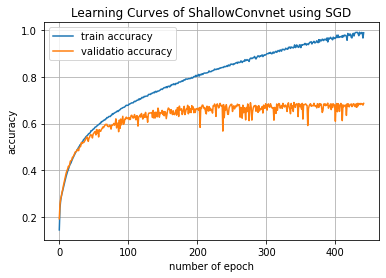

In [ ]:
plt.plot(range(442), train_accuracies, label ='train accuracy' )
plt.plot (range(442), val_accuracies, label = 'validatio accuracy')
plt.xlabel('number of epoch')
plt.ylabel ("accuracy")
plt.grid()
plt.legend ()
plt.title("Learning Curves of ShallowConvnet using SGD")

### Q2.4 Simple convolution network - 

Design a convolutional neural network with the following specification: 
For each convolution layer, use appropriate padding such that it maintains the resolution of the image. The resolution should be changing only when you introduce maxpooling layers. E**ach convolution layer should be followed by a relu non-linearity**. The first two blocks containing 3 convolutional layers are each followed by a maxpooling layer **that halves the resolution of the image**. After the third block, use maxpooling to get a resolution of 1 X 1. Finally, apply a linear transformation to project to the number of classes. 

Structure of the convolution layers of the model:
1. Number of input channels to the model = 3
2. First convolution layer of kernel size 5 with filter size 64 and padding such that it maintains the resolution of the image.
3. Followed by a block of 3 convolution layers of kernel size 3, filter size 64 and padding such that it maintains the resolution of the image.
5. Followed by 3 convolution layers of kernel size 3, filter size 128 and padding such that it maintains the resolution of the image.
6. Followed by 3 convolution layers of kernel size 3, filter size 256 and padding such that it maintains the resolution of the image. 




In [ ]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()
        #super().__init__()
        self.first_layer = nn.Sequential(
                  nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2),
                  nn.ReLU()
        )
        self.first_block = nn.Sequential(
                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  
                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  
                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2)  # it halves the resolution of the image             
        )
        self.second_block = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
         
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
         
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)  # it halves the resolution of the image             
            )
        
        self.third_block = nn.Sequential(
          nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(),        
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(),         
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=8)  # it makes the resolution 1*1 size         
            )
        self.projection = nn.Sequential(
            View((-1,256)),
            nn.Linear(256, num_classes)
        )
        
        # TODO

    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        x = self.first_layer(x)

        # HINT: block of 3 conv 
        x = self.first_block(x)

        # HINT : block of 3 conv 
        x = self.second_block(x)

        # HINT: block of 3 conv 
        x = self.third_block (x)

        # HINT: projection 
        x = self.projection(x)
        output = x
        return output
        

In [ ]:

# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(input_channels =3, num_classes = 10)
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses,val_acc = train_loop(model, criterion, optimizer,  train_loader, val_loader,50)
import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_1_3', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_1_3', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_without_batch_SGD_1_3', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_1_3', val_acc)

[EPOCH]: 0, [TRAIN LOSS]: 2.303275, [TRAIN ACCURACY]: 0.101
[EPOCH]: 0, [VAL LOSS]: 2.303614, [VAL ACCURACY]: 0.097 

[EPOCH]: 1, [TRAIN LOSS]: 2.303229, [TRAIN ACCURACY]: 0.101
[EPOCH]: 1, [VAL LOSS]: 2.303552, [VAL ACCURACY]: 0.097 

[EPOCH]: 2, [TRAIN LOSS]: 2.303183, [TRAIN ACCURACY]: 0.100
[EPOCH]: 2, [VAL LOSS]: 2.303495, [VAL ACCURACY]: 0.097 

[EPOCH]: 3, [TRAIN LOSS]: 2.303130, [TRAIN ACCURACY]: 0.101
[EPOCH]: 3, [VAL LOSS]: 2.303443, [VAL ACCURACY]: 0.097 

[EPOCH]: 4, [TRAIN LOSS]: 2.303087, [TRAIN ACCURACY]: 0.101
[EPOCH]: 4, [VAL LOSS]: 2.303394, [VAL ACCURACY]: 0.097 

[EPOCH]: 5, [TRAIN LOSS]: 2.303043, [TRAIN ACCURACY]: 0.100
[EPOCH]: 5, [VAL LOSS]: 2.303349, [VAL ACCURACY]: 0.097 

[EPOCH]: 6, [TRAIN LOSS]: 2.303005, [TRAIN ACCURACY]: 0.101
[EPOCH]: 6, [VAL LOSS]: 2.303307, [VAL ACCURACY]: 0.097 

[EPOCH]: 7, [TRAIN LOSS]: 2.302975, [TRAIN ACCURACY]: 0.101
[EPOCH]: 7, [VAL LOSS]: 2.303267, [VAL ACCURACY]: 0.097 

[EPOCH]: 8, [TRAIN LOSS]: 2.302949, [TRAIN ACCURACY]: 0.

### Q 2.5 Report results of training using SGD optimizer for both ShallowNet and SimpleConvnet. What do you observe?

Train accuracies of both ShallowNet and SimpleConvnet using SGD optmizer is 1.0 and 0.1. This means SGD opmizer (lr = 1e-3) does not work on training SimpleCovent. 


**-- In case of ShallowConvnet, using learning rate as 1.0 results in 'nan' values of train and value accuracies. Thus I have set learning rate as 0.5 instead of 1.0 **



**Train shallow convolution network**


In [ ]:
# TODO : Initialize the model and cast to correct device
model = ShallowConvnet(input_channels=3, num_classes=10)
model.to (device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_acc = train_loop(model, criterion, optimizer,  train_loader, val_loader,50)
import numpy as np
'''
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_Shallow_0_1', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_Shallow_0_1', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_without_batch_SGD_Shallow_0_1', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_Shallow_0_1', val_acc)
'''
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_Shallow_0_5', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_Shallow_0_5', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_without_batch_SGD_Shallow_0_5', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_Shallow_0_5', val_acc)


**Train simple convolution network**

In [ ]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(input_channels =3, num_classes = 10)
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 
#optimizer = torch.optim.SGD(model.parameters(), lr=1.0) 
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses,val_acc = train_loop(model, criterion, optimizer,  train_loader, val_loader,50)
import numpy as np

np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_0_1', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_0_1', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_without_batch_SGD_0_1', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_0_1', val_acc)
'''
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_1_0', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_1_0', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_without_batch_SGD_1_0', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_1_0', val_acc)
'''

**Load plotting data**

In [ ]:
import numpy as np
# load SimpleConvnet data, learning rate = 1.0
#train_losses_1_0 = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_1_0.npy')
train_accuracies_1_0 = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_1_0.npy',allow_pickle= True)
val_acc_1_0 = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_1_0.npy', allow_pickle= True)

# load Shallow Convenet data ,learning rate = 0.5
train_accuracies_shallow_0_5 =np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_Shallow_0_5.npy', allow_pickle= True)
val_acc_shallow_0_5 = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_Shallow_0_5.npy', allow_pickle= True)

# load SimpleConvnet data, lr = 0.1
train_accuracies_0_1 = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_0_1.npy',allow_pickle= True)
val_acc_0_1 = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_0_1.npy', allow_pickle= True)
# load Shallow Convenet data, lr = 0.1
train_accuracies_shallow_0_1 =np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_Shallow_0_1.npy', allow_pickle= True)
val_acc_shallow_0_1 = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_SGD_Shallow_0_1.npy', allow_pickle= True)



**Plot train and validation accuracies**

Text(0.5, 1.0, 'Train and Validation Accuracy Comparison, (lr = 0.1)')

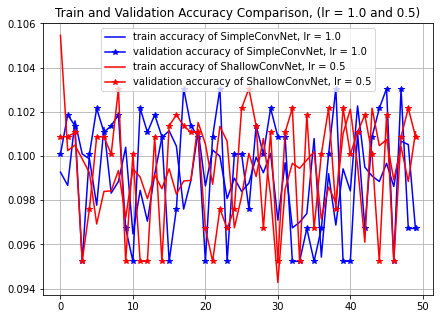

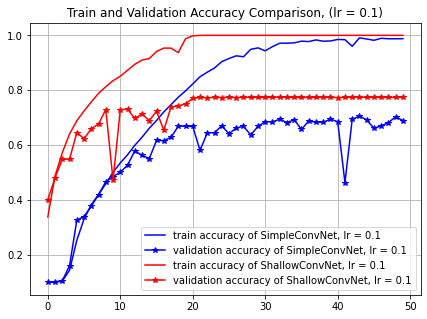

In [ ]:
plt.figure (1, figsize= (7,5))
plt.plot ((range (len (train_accuracies_1_0))), train_accuracies_1_0, 'b', label = 'train accuracy of SimpleConvNet, lr = 1.0')
plt.plot ((range (len (val_acc_1_0))), val_acc_1_0,'b-*', label = 'validation accuracy of SimpleConvNet, lr = 1.0')

plt.plot ((range (len (train_accuracies_shallow_0_5))), train_accuracies_shallow_0_5, 'r', label = 'train accuracy of ShallowConvNet, lr = 0.5')
plt.plot ((range (len (val_acc_shallow_0_5))), val_acc_shallow_0_5,'r-*', label = 'validation accuracy of ShallowConvNet, lr = 0.5')
plt.legend()
plt.grid()
plt.title ('Train and Validation Accuracy Comparison, (lr = 1.0 and 0.5)')

plt.figure (2, figsize = (7,5))
plt.plot ((range (len (train_accuracies_0_1))), train_accuracies_0_1, 'b', label = 'train accuracy of SimpleConvNet, lr = 0.1')
plt.plot ((range (len (val_acc_0_1))), val_acc_0_1,'b-*', label = 'validation accuracy of SimpleConvNet, lr = 0.1')

plt.plot ((range (len (train_accuracies_shallow_0_1))), train_accuracies_shallow_0_1, 'r', label = 'train accuracy of ShallowConvNet, lr = 0.1')
plt.plot ((range (len (val_acc_shallow_0_1))), val_acc_shallow_0_1,'r-*', label = 'validation accuracy of ShallowConvNet, lr = 0.1')
plt.legend()
plt.grid()
plt.title ('Train and Validation Accuracy Comparison, (lr = 0.1)')

The above figures show that the large learning rate values do not contribute to learning of both SimpleConvNet and ShallowConvNet.

When learning rate is 0.1, ShallowConvNet shows better performance than SimpleConvNet.

### Q 2.6 Add batch normalization

#### Q2.6 a After each relu layer, add a batch normalization layer to the network SimpleConvnet you created above

In [ ]:
class SimpleConvnet2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet2, self).__init__()
       
        self.first_layer = nn.Sequential(
                  nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2),
                  nn.ReLU(),
                  nn.BatchNorm2d(64))
        self.first_block = nn.Sequential(
                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  
                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),

                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.MaxPool2d(kernel_size=2, stride=2)  # it halves the resolution of the image             
        )
        self.second_block = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
         
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
         nn.BatchNorm2d(128),

          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(kernel_size=2, stride=2)  # it halves the resolution of the image             
            )
        
        self.third_block = nn.Sequential(
          nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),

          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(), 
          nn.BatchNorm2d(256),

          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.MaxPool2d(kernel_size=8)  # it makes the resolution 1*1 size         
            )
        self.projection = nn.Sequential(
            View((-1,256)),
            nn.Linear(256, num_classes)
        )
        
    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        x = self.first_layer(x)

        # HINT: block of 3 conv 
        x = self.first_block(x)

        # HINT : block of 3 conv 
        x = self.second_block(x)

        # HINT: block of 3 conv 
        x = self.third_block (x)

        # HINT: projection 
        x = self.projection(x)
        output = x
        
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(input_channels =3, num_classes = 10)
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 
# TODO : Run the training loop using this model
train_losses_b, train_accuracies_b, val_losses_b,val_acc_b = train_loop(model, criterion, optimizer,  train_loader, val_loader,50)
import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_with_batch_SGD', train_losses_b)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_with_batch_SGD', train_accuracies_b)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_with_batch_SGD', val_losses_b)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_with_batch_SGD', val_acc_b)

#### Q2.6 b Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) using SGD (lr 1e-3) with and without batch normalization. Comment on the difference. 

In [3]:
import numpy as np
train_losses_without_batch = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_SGD_1_3.npy')
train_accuracies_without_batch = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_SGD_1_3.npy', allow_pickle=True)
train_losses_with_batch = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_with_batch_SGD.npy', allow_pickle=True)
train_accuracies_with_batch = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_with_batch_SGD.npy', allow_pickle=True)


Text(0.5, 1.0, 'Train Loss Comparison (SimpleConvNet, lr = 1e-3)')

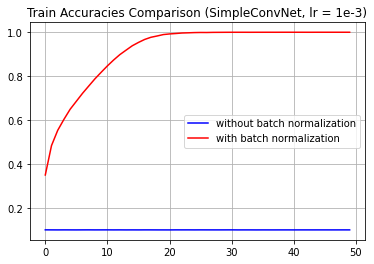

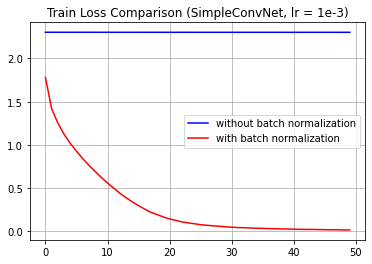

In [4]:
plt.figure(1)
plt.plot (range(50),train_accuracies_without_batch, 'b',label = "without batch normalization")
plt.plot (range(50),train_accuracies_with_batch,'r', label = "with batch normalization")
plt.grid()
plt.legend()
plt.title ('Train Accuracies Comparison (SimpleConvNet, lr = 1e-3)')


plt.figure (2)
plt.plot (range(50),train_losses_without_batch,'b', label = "without batch normalization")
plt.plot (range(50),train_losses_with_batch,'r', label = "with batch normalization")
plt.grid()
plt.legend()
plt.title ('Train Loss Comparison (SimpleConvNet, lr = 1e-3)')


Using batch normalization improves the performance a lot in terms of train accuracies.


#### Q2.6 c. Try running the same two networks with an Adam optimizer (lr 1e-4). Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) with and without batch normalization. Comment on the difference. 

In [ ]:
# Without batch normalization
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(input_channels =3, num_classes = 10) # set epoch as 100
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses,val_acc = train_loop(model, criterion, optimizer,  train_loader, val_loader,100)
import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_without_batch_adam', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_without_batch_adam', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_without_batch_adam', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_without_batch_adam', val_acc)

# With batch normalization
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(input_channels =3, num_classes = 10) # set eposh as 100
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
# TODO : Run the training loop using this model
train_losses_b, train_accuracies_b, val_losses_b,val_acc_b = train_loop(model, criterion, optimizer,  train_loader, val_loader,100)
import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_with_batch_adam', train_losses_b)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_with_batch_adam', train_accuracies_b)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_with_batch_adam', val_losses_b)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_with_batch_adam', val_acc_b)



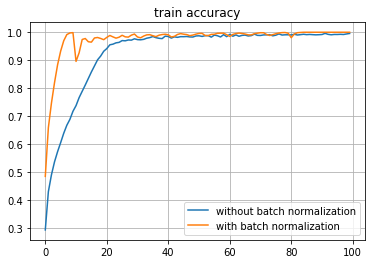

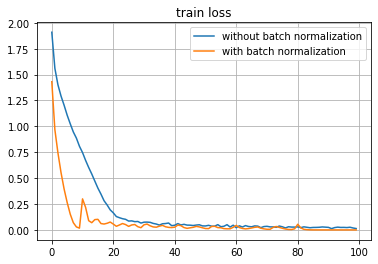

In [ ]:


plt.figure(1)
plt.plot (range(100),train_accuracies, label = "without batch normalization")
plt.plot (range(100),train_accuracies_b, label = "with batch normalization")
plt.grid()
plt.legend()
plt.title ('Train Accuracy using Adam Optimizer')
)

plt.figure (2)
plt.plot (range(100),train_losses, label = "without batch normalization")
plt.plot (range(100),train_losses_b, label = "with batch normalization")
plt.grid()
plt.legend()
plt.title ('Train Loss using Adam Optimizer ')


**The figures show that employing batch normalization leads the train accuracy to converge fast. Also the train loss reduce faster than not using batch normalization. In addition, when utilizing Adam optimizer, regardless of batch normalization, we can get good train accuracies after enough number of epoch.**

#### Q2.6 d Once you choose an optimizer and see that it does train, make sure your model has enough capacity by overfitting on one batch of the data set. You should be able to get 100% train accuracy. 


### Q 2.7 Add residual connections

#### Residual connections help stabilise training and lead to faster convergence. In this question you will introduce residual connections into the SimpleConvnet2 model that you built above. 

We will add residual connections after each block of 3 convolutional layers. Lets consider the first block of three convolutional layers. The input to this block, the so called residual, is added to the output of the block before the final batch normalization layer of that block. 


IMP NOTE: You will notice that the number of filters of these two summands are not the same. For this, you will need to use a convolution layer on the residual component, which changes the number of filters while keeping the rest of the dimensions the same. This can be achieved with a careful selection of the input_channels, output_channels, kernel_size and padding parameters. 

In [ ]:
class ResidualConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResidualConvnet, self).__init__()
        ## first layer
        self.first_layer = nn.Sequential(
                  nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2),
                  nn.ReLU(),
                  nn.BatchNorm2d(64))
        
        ## first block
        self.first_block = nn.Sequential(
                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  
                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),

                  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
                  nn.ReLU()
        )
        self.first_BatchNorm_MaxPool = nn.Sequential(         ##
                  nn.BatchNorm2d(64),
                  nn.MaxPool2d(kernel_size=2, stride=2)  # it halves the resolution of the image             
        ) 
         
        # second block
        self.second_block = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
         
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU(),
         nn.BatchNorm2d(128),

          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
          nn.ReLU()
          )
        self.second_BatchNorm_MaxPool = nn.Sequential(
          nn.BatchNorm2d(128),
          nn.MaxPool2d(kernel_size=2, stride=2)  # it halves the resolution of the image             
            )
          # change the number of input channel as that of output chanel
        self.conv_64_128 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)

        ## thrid block
        self.third_block = nn.Sequential(
          nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),

          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU(), 
          nn.BatchNorm2d(256),

          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
          nn.ReLU()
          )
        self.thrid_BatchNorm_MaxPool = nn.Sequential(
          nn.BatchNorm2d(256),
          nn.MaxPool2d(kernel_size=8)  # it makes the resolution 1*1 size         
            )
          # change the number of input channel as that of output chanel
        self.conv_128_256 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)

        # projection layer
        self.projection = nn.Sequential(
            View((-1,256)),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # TODO 

        # first conv layer 
        x_first_layer = self.first_layer(x)

        # let's make residual net here
        x_first_b = self.first_block(x_first_layer) + x_first_layer
        # after then do batch normalization
        x_first_b = self.first_BatchNorm_MaxPool(x_first_b) # channel number is 64

        #  make residual net but we need to make the number of chanel same
        x_second_b = self.second_block(x_first_b) + self.conv_64_128(x_first_b) # chanel number is 128
        x_second_b = self.second_BatchNorm_MaxPool(x_second_b) # bathc normalization

        # in the same way
        x_third_b = self.third_block (x_second_b) + self.conv_128_256(x_second_b)
        x_third_b = self.thrid_BatchNorm_MaxPool(x_third_b)

        #  projection 
        output = self.projection(x_third_b)
        
        return output
        

In [ ]:
# With batch normalization
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(input_channels =3, num_classes = 10)
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
# TODO : Run the training loop using this model
train_losses_b_res, train_accuracies_b_res, val_losses_b_res, val_acc_b_rs = train_loop(model, criterion, optimizer,  train_loader, val_loader, 100)
import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_res_batch', train_losses_b_res)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_res_batch', train_accuracies_b_res)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_res_batch', val_losses_b_res)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_res_batch', val_acc_b_rs)

[EPOCH]: 0, [TRAIN LOSS]: 1.361532, [TRAIN ACCURACY]: 0.522
[EPOCH]: 0, [VAL LOSS]: 1.083446, [VAL ACCURACY]: 0.619 

[EPOCH]: 1, [TRAIN LOSS]: 0.882581, [TRAIN ACCURACY]: 0.699
[EPOCH]: 1, [VAL LOSS]: 0.866043, [VAL ACCURACY]: 0.695 

[EPOCH]: 2, [TRAIN LOSS]: 0.652426, [TRAIN ACCURACY]: 0.786
[EPOCH]: 2, [VAL LOSS]: 0.781289, [VAL ACCURACY]: 0.725 

[EPOCH]: 3, [TRAIN LOSS]: 0.476911, [TRAIN ACCURACY]: 0.854
[EPOCH]: 3, [VAL LOSS]: 0.715825, [VAL ACCURACY]: 0.750 

[EPOCH]: 4, [TRAIN LOSS]: 0.326474, [TRAIN ACCURACY]: 0.912
[EPOCH]: 4, [VAL LOSS]: 0.671482, [VAL ACCURACY]: 0.767 

[EPOCH]: 5, [TRAIN LOSS]: 0.197532, [TRAIN ACCURACY]: 0.959
[EPOCH]: 5, [VAL LOSS]: 0.677580, [VAL ACCURACY]: 0.770 

[EPOCH]: 6, [TRAIN LOSS]: 0.097312, [TRAIN ACCURACY]: 0.989
[EPOCH]: 6, [VAL LOSS]: 0.667291, [VAL ACCURACY]: 0.777 

[EPOCH]: 7, [TRAIN LOSS]: 0.043209, [TRAIN ACCURACY]: 0.998
[EPOCH]: 7, [VAL LOSS]: 0.670009, [VAL ACCURACY]: 0.787 

[EPOCH]: 8, [TRAIN LOSS]: 0.016203, [TRAIN ACCURACY]: 1.

### Q 2.8 Plot the training curves with and without the residual connection. Comment on the difference. 

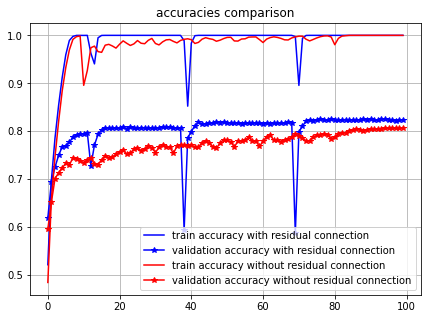

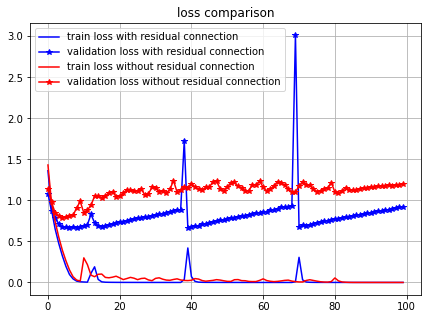

In [ ]:
train_losses_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_res_batch.npy')
train_accuracies_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_res_batch.npy', allow_pickle= True)
val_losses_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/val_loss_res_batch.npy', allow_pickle= True)
val_acc_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_res_batch.npy', allow_pickle= True)

train_losses_b = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_with_batch_adam.npy', allow_pickle=True)
train_accuracies_b = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_with_batch_adam.npy', allow_pickle= True)
val_losses_b = np.load ('/content/drive/My Drive/Colab Notebooks/val_loss_with_batch_adam.npy', allow_pickle= True)
val_acc_b = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_with_batch_adam.npy', allow_pickle= True)

plt.figure(1, figsize = (7,5))
plt.plot (range(100),train_accuracies_b_res, 'b',label = "train accuracy with residual connection")
plt.plot (range(100),val_acc_b_res,'b-*', label = "validation accuracy with residual connection")
plt.plot (range(100),train_accuracies_b, 'r', label = "train accuracy without residual connection")
plt.plot (range(100),val_acc_b, 'r-*',label = "validation accuracy without residual connection")
plt.grid()
plt.legend()
plt.title ("accuracies comparison")
plt.savefig('train_residual_comp.png')

plt.figure (2, figsize=(7,5))
plt.plot (range(100),train_losses_b_res, 'b' , label = "train loss with residual connection")
plt.plot (range(100),val_losses_b_res , 'b-*', label = "validation loss with residual connection")
plt.plot (range(100),train_losses_b , 'r' , label = "train loss without residual connection")
plt.plot (range(100),val_losses_b , 'r-*', label = "validation loss without residual connection")
plt.grid()
plt.legend()
plt.title ("loss comparison")
plt.savefig('loss_residual_comp.png')

**The figures show tha using residual connection improves the train accuracy and reduce the amount of loss compared to the case without residual connection. Also gap between train and validation accuracies (loss) decreses thanks to residual connections.**

### Q2.9 Reducing overfiting 



In the previous questions, you might have observed that there is a large difference between the training and validation losses. This is a sign that the model is overfitting. One way to combat this is by adding **random transformations to the input data** to make your model more robust and prevent it from memorizing the input data. 

Torchvision **provides several transforms **that you can readily apply to your data. **Experiment with adding a few transforms** and report your results in terms of learning curves to see if the gap between the training and validation loss reduces and **try to achieve better perfomance on the validation set**. 

In [ ]:
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here 
                                      #transforms.Scale(32,32),                              
                                      transforms.RandomHorizontalFlip(),
                                      #transforms.ColorJitter (),  
                                      #transforms.RandomVerticalFlip(),
                                      transforms.RandomCrop(size=32, padding=4),
                                      #transforms.RandomRotation(90),
                                      #transforms.RandomResizedCrop(size=32),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])
## https://pytorch.org/docs/stable/torchvision/transforms.html
#https://www.programcreek.com/python/example/104838/torchvision.transforms.RandomCrop

In [ ]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [ ]:
bs = 128
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)

#### Use **the residual network** that you built above and use data augmentation to reduce the overfitting 

In [ ]:
# With batch normalization
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(input_channels =3, num_classes = 10)
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
# TODO : Run the training loop using this model
train_losses_rand_trans, train_accuracies_rand_trans, val_losses_rand_trans,val_acc_rand_trans = train_loop(model, criterion, optimizer,  train_loader, val_loader, 100)
import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_rand_trans', train_losses_rand_trans)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_rand_trans', train_accuracies_rand_trans)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_rand_trans', val_losses_rand_trans)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_rand_trans', val_acc_rand_trans)

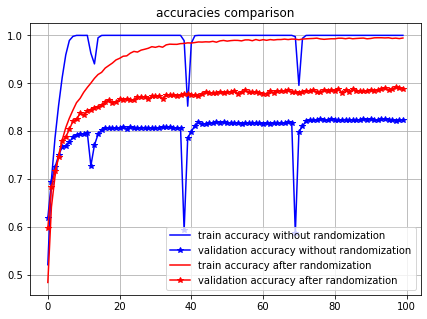

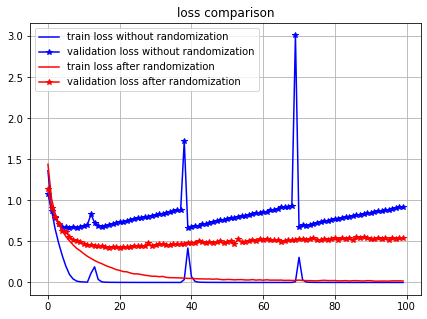

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

train_losses_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_rand_trans.npy')
train_accuracies_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_rand_trans.npy', allow_pickle= True)
val_losses_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/val_loss_rand_trans.npy', allow_pickle= True)
val_acc_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_rand_trans.npy', allow_pickle= True)

train_losses_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_res_batch.npy',allow_pickle= True)
train_accuracies_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_res_batch.npy', allow_pickle=True)
val_losses_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/val_loss_res_batch.npy', allow_pickle=True)
val_acc_b_res = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_res_batch.npy', allow_pickle= True)

plt.figure(1, figsize = (7,5))
plt.plot (range(100),train_accuracies_b_res, 'b',label = "train accuracy without randomization")
plt.plot (range(100),val_acc_b_res,'b-*', label = "validation accuracy without randomization")
plt.plot (range(100),train_accuracies_rand_trans, 'r', label = "train accuracy after randomization")
plt.plot (range(100),val_acc_rand_trans, 'r-*',label = "validation accuracy after randomization")
plt.grid()
plt.legend()
plt.title ("accuracies comparison")
plt.savefig('train_residual_comp.png')

plt.figure (2, figsize=(7,5))
plt.plot (range(100),train_losses_b_res, 'b' , label = "train loss without randomization")
plt.plot (range(100),val_losses_b_res , 'b-*', label = "validation loss without randomization")
plt.plot (range(100),train_losses_rand_trans , 'r' , label = "train loss after randomization")
plt.plot (range(100),val_losses_rand_trans , 'r-*', label = "validation loss after randomization")
plt.grid()
plt.legend()
plt.title ("loss comparison")
plt.savefig('loss_residual_comp.png')


As we can see, after randomization of input data, the gap between train and validation accuracies becomes smaller. Accordingly, the discrepancy between train and validation loss is reduced comparably.

# 

### Q 2.10  Effect of learning rate decay 

#### Here you need to change the training loop to have one additional operation - add the scheduler step at the end of each epoch. Experiment with different learning rate schedulers provided by pytorch. Report results using atleast StepLR. 

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import MultiplicativeLR


In [ ]:
def train_loop2(model, criterion, optimizer,  train_loader, val_loader,n_epoch, g = 0):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 100
    patience_counter = 0
    
    
    #scheduler = CyclicLR(optimizer, base_lr=0.008, max_lr= 0.12)
    #scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
    if g == 0:
      scheduler = CosineAnnealingLR (optimizer, T_max = 10  ) 
    else:
      scheduler = StepLR(optimizer, step_size=10, gamma=g)
      print (f'use Step LR scheduler ! gamma = {g}')
      

    # Training
    for t in tqdm(range(n_epoch)):

      epoch_t_acc = 0.0 
      epoch_t_loss = 0.0

      # TODO : Set the model to train mode
      #model.to(device)       
      model.train()
      # TODO: Loop over the training set
      for train_data, targets in train_loader:
        # TODO: Put the inputs and targets on the write device
        train_data = train_data.to(device)
        targets = targets.to (device)
        # TODO: Feed forward to get the logits
        y_pred = model.forward(train_data)
        score, predicted = torch.max(y_pred, 1)
        
        # TODO: Compute the loss and accuracy

        loss = criterion ( y_pred,targets) 
        # TODO: zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
        # TODO: Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
        # TODO: Update params
        optimizer.step()
        # TODO: Keep track of accuracy and loss
        train_accuracy = (targets == predicted).sum().float() / len(targets)

        epoch_t_acc += train_accuracy
        epoch_t_loss += loss.item()

      train_losses.append(epoch_t_loss/len(train_loader))
      train_accuracies.append(epoch_t_acc/len(train_loader))

        # TODO: Switch the model to eval mode
      model.eval()

      v_acc = 0
      v_loss = 0  
      with torch.no_grad():
          # TODO: Loop over the validation set 
          for val_data, targets in val_loader:
              # TODO: Put the inputs and targets on the write device
              val_data = val_data.to(device)
              targets = targets.to(device)
              # TODO: Feed forward to get the logits
              y_pred_val = model (val_data)
              score, predicted = torch.max(y_pred_val, 1)
              # TODO: Compute the loss and accuracy
              loss_val = criterion ( y_pred_val,targets)
              accuracy_val = (targets == predicted).sum().float() / len(targets)
              # TODO: Keep track of accuracy and loss
              v_acc += accuracy_val
              v_loss += loss_val

      val_losses.append(v_loss/len(val_loader))
      val_accuracies.append(v_acc/len(val_loader))

      if val_accuracies[-1] > best_val:
        best_val = val_accuracies[-1]
        patience_counter = 0

        # TODO: Save best model, optimizer, epoch_number
        torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': t,
                }, '/content/drive/My Drive/Colab Notebooks/checkpoint.pth')
      else:
        patience_counter += 1    
        if patience_counter > max_patience: 
          break

      print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
      print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies

I use the 'cosine annealing scheduler', ***CosineAnnealingLR***,  which changes learning rate periodically 

In [ ]:
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(input_channels =3, num_classes = 10)
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()
# TODO : Initialize the Adam optimizer with lr 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 

# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses,val_acc = train_loop2(model, criterion, optimizer,  train_loader, val_loader,100)

import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_learning_rate', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_learning_rate', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_learning_rate', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_learning_rate', val_acc)

[EPOCH]: 0, [TRAIN LOSS]: 1.452441, [TRAIN ACCURACY]: 0.477
[EPOCH]: 0, [VAL LOSS]: 1.152514, [VAL ACCURACY]: 0.597 

[EPOCH]: 1, [TRAIN LOSS]: 1.021599, [TRAIN ACCURACY]: 0.641
[EPOCH]: 1, [VAL LOSS]: 0.907208, [VAL ACCURACY]: 0.683 

[EPOCH]: 2, [TRAIN LOSS]: 0.842696, [TRAIN ACCURACY]: 0.707
[EPOCH]: 2, [VAL LOSS]: 0.787722, [VAL ACCURACY]: 0.726 

[EPOCH]: 3, [TRAIN LOSS]: 0.714066, [TRAIN ACCURACY]: 0.753
[EPOCH]: 3, [VAL LOSS]: 0.689973, [VAL ACCURACY]: 0.761 

[EPOCH]: 4, [TRAIN LOSS]: 0.626379, [TRAIN ACCURACY]: 0.785
[EPOCH]: 4, [VAL LOSS]: 0.644423, [VAL ACCURACY]: 0.776 

[EPOCH]: 5, [TRAIN LOSS]: 0.558245, [TRAIN ACCURACY]: 0.810
[EPOCH]: 5, [VAL LOSS]: 0.596554, [VAL ACCURACY]: 0.794 

[EPOCH]: 6, [TRAIN LOSS]: 0.500515, [TRAIN ACCURACY]: 0.828
[EPOCH]: 6, [VAL LOSS]: 0.554425, [VAL ACCURACY]: 0.813 

[EPOCH]: 7, [TRAIN LOSS]: 0.454677, [TRAIN ACCURACY]: 0.844
[EPOCH]: 7, [VAL LOSS]: 0.530911, [VAL ACCURACY]: 0.818 

[EPOCH]: 8, [TRAIN LOSS]: 0.417344, [TRAIN ACCURACY]: 0.

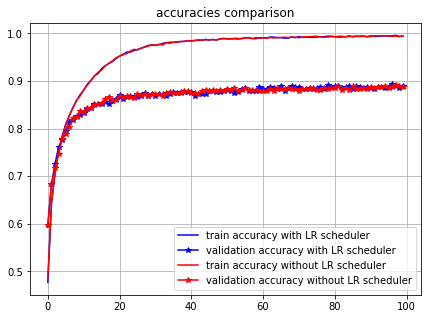

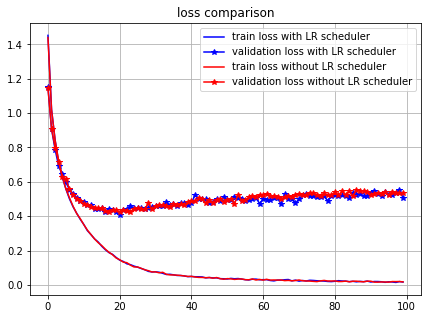

In [ ]:
import numpy as np
train_losses_lr = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_learning_rate.npy')
train_accuracies_lr = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_learning_rate.npy', allow_pickle=True)
val_losses_lr = np.load('/content/drive/My Drive/Colab Notebooks/val_loss_learning_rate.npy', allow_pickle= True)
val_acc_lr = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_learning_rate.npy', allow_pickle= True)

train_losses_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/train_loss_rand_trans.npy')
train_accuracies_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/train_acc_rand_trans.npy', allow_pickle= True)
val_losses_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/val_loss_rand_trans.npy', allow_pickle= True)
val_acc_rand_trans = np.load ('/content/drive/My Drive/Colab Notebooks/val_acc_rand_trans.npy', allow_pickle= True)

plt.figure(1, figsize = (7,5))
plt.plot (range(100),train_accuracies_lr[0:100], 'b',label = "train accuracy with LR scheduler")
plt.plot (range(100),val_acc_lr[0:100],'b-*', label = "validation accuracy with LR scheduler")
plt.plot (range(100),train_accuracies_rand_trans, 'r', label = "train accuracy without LR scheduler")
plt.plot (range(100),val_acc_rand_trans, 'r-*',label = "validation accuracy without LR scheduler")
plt.grid()
plt.legend()
plt.title ("accuracies comparison")
plt.savefig('train_residual_comp.png')

plt.figure (2, figsize=(7,5))
plt.plot (range(100),train_losses_lr[0:100], 'b' , label = "train loss with LR scheduler")
plt.plot (range(100),val_losses_lr[0:100] , 'b-*', label = "validation loss with LR scheduler")
plt.plot (range(100),train_losses_rand_trans , 'r' , label = "train loss without LR scheduler")
plt.plot (range(100),val_losses_rand_trans , 'r-*', label = "validation loss without LR scheduler")
plt.grid()
plt.legend()
plt.title ("loss comparison")
plt.savefig('loss_residual_comp.png')



In the figures the valication accuracy and loss curve of using LR scheduler shows better performance than the case without using LR scheduler. Thus, using the scheduler of learning rate improves the performance a little bit more. 



### Q2.11 Hyper parameter tuning 


#### Experiment with a range of learning rates and optimizers, as well as the parameter in the learning rate scheduler for StepLR. Report the following plots: 

1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)





In [ ]:
# TODO : Initialize the model and cast to correct device
import numpy as np
def run_model(running_list,name, opt_type = 'Adam', scheduler = False):
  if scheduler == True:
    for i, g in enumerate(running_list):
      
      model = ResidualConvnet(input_channels =3, num_classes = 10)
      model.to(device)
      # TODO : Initialize the criterion
      criterion = torch.nn.CrossEntropyLoss()
      # TODO : Initialize the Adam optimizer with lr 1e-4
      optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
      train_losses, train_accuracies, val_losses,val_acc = train_loop2(model, criterion, optimizer,  train_loader, val_loader,100, g)
      np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_learning_rate_StepLR_'+ name[i], train_losses)
      np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_learning_rate_StepLR_'+name[i], train_accuracies)
      np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_learning_rate_StepLR_'+name[i], val_losses)
      np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_learning_rate_StepLR_'+ name[i], val_acc)
  else:
    for i, lr in enumerate(running_list):
      model = ResidualConvnet(input_channels =3, num_classes = 10)
      model.to(device)
      # TODO : Initialize the criterion
      criterion = torch.nn.CrossEntropyLoss()
      # TODO : Initialize the Adam optimizer with lr 1e-4

      if opt_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
      else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr) 

      # TODO : Run the training loop using this model
      # use cosine annealing scheduler
      train_losses, train_accuracies, val_losses,val_acc = train_loop2(model, criterion, optimizer,  train_loader, val_loader,230)
      if opt_type == 'Adam':
        np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_learning_rate_adam_'+ name[i], train_losses)
        np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_learning_rate_adam_'+name[i], train_accuracies)
        np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_learning_rate_adam_'+name[i], val_losses)
        np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_learning_rate_adam_'+ name[i], val_acc)
      else:
        np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_learning_rate_'+ name[i], train_losses)
        np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_learning_rate_'+name[i], train_accuracies)
        np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_learning_rate_'+name[i], val_losses)
        np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_learning_rate_'+ name[i], val_acc)

#running_list = [1e-3, 5e-4, 1e-4, 1e-5, 1e-6]
#names = ['1_3', '5_4', '1_4', '1_5', '1_6']
#run_model(running_list, names, opt_type = 'SGD')
#run_model(running_list, names, opt_type = 'Adam')

#running_list = [0.1, 0.75,1.1, 0.99, 0.5 ]
#names = ['0_1', '07_5','1_1', '09_9', '0_5' ]
#running_list = [0.99, 0.5, 0.1, 0.75]
#names = [ '09_9', '0_5', '0_1', '07_5']

running_list = [ 0.01, 0.001, 0.0005]
names = [ '0_01', '0_001', '0_0005']

run_model(running_list, names, opt_type = 'Adam', scheduler = True)


In [ ]:

def plotting (sub_name_acc, sub_name_loss, name , label):

  plt.figure(1, figsize=(7,5))
  for i, s in enumerate(name):
    filename = '/content/drive/My Drive/Colab Notebooks/' +sub_name_acc + s + '.npy'
    train_loss = np.load (filename, allow_pickle= True)
    #plt.yscale('log')
    plt.plot ( train_loss,label= 'lr='+label[i] )
  plt.grid()
  plt.legend()
  plt.title ('train loss')

  plt.figure (2,figsize = (7,5))
  for i, s in enumerate(name):
    filename = '/content/drive/My Drive/Colab Notebooks/'+ sub_name_loss + s + '.npy'
    train_loss = np.load (filename, allow_pickle= True)
    #plt.yscale('log')
    plt.plot ( train_loss,label= 'lr='+label[i] )
  plt.grid()
  plt.legend()
  plt.title ('validation loss')


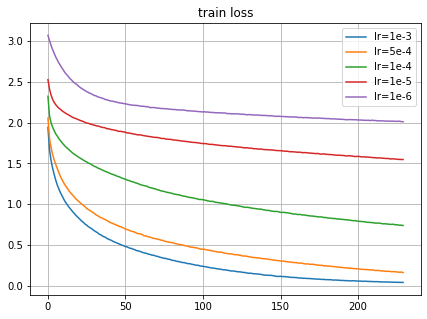

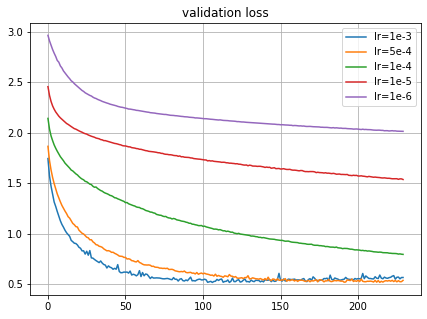

In [ ]:
name = ['1_3','5_4','1_4', '1_5','1_6']
label = ['1e-3','5e-4', '1e-4',  '1e-5', '1e-6']
# 1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
plotting ('train_loss_learning_rate_', 'val_loss_learning_rate_', name, label)

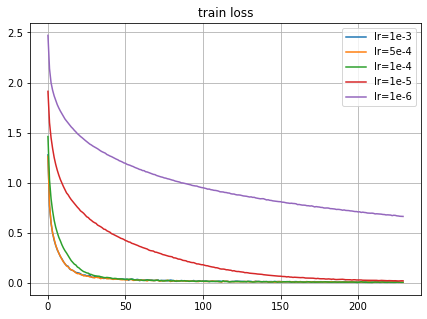

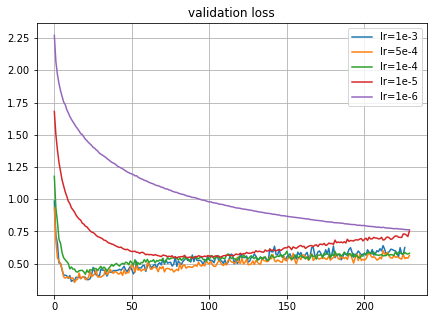

In [ ]:
# 2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
plotting ('train_loss_learning_rate_adam_', 'val_loss_learning_rate_adam_', name , label)

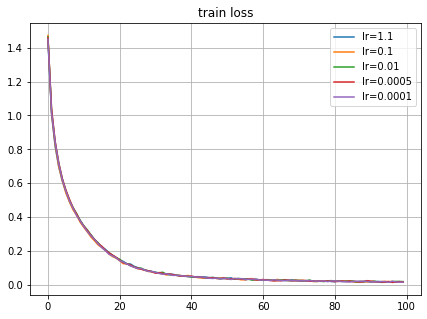

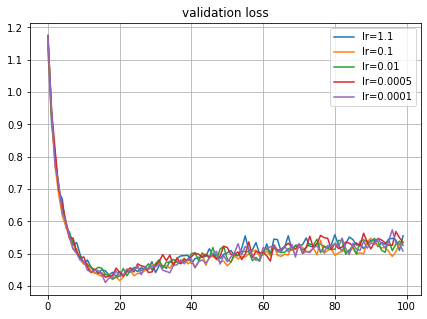

In [ ]:
# 3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)
#name = ['1_1','0_5','09_9', '07_5','0_1']
#label = ['1.1','0.5', '0.99',  '0.75', '0.1']

name = ['1_1','0_1','0_01','0_0005',"0_0001"]
label = ['1.1','0.1', '0.01','0.0005','0.0001']
plotting ('train_loss_learning_rate_StepLR_', 'val_loss_learning_rate_StepLR_', name, label)

I set 'step_size' as 10 when using StepLR scheduler. I didn't observe performance enhancement by changing the value of learning rate. 


**final training using cosine annealing scheduler**

In [ ]:

# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(input_channels =3, num_classes = 10)
model.to(device)
# TODO : Initialize the criterion
criterion = torch.nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=6e-4) 
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) 

# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses,val_acc = train_loop2(model, criterion, optimizer,  train_loader, val_loader,500)


import numpy as np
np.save ('/content/drive/My Drive/Colab Notebooks/train_loss_final', train_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/train_acc_final', train_accuracies)
np.save ('/content/drive/My Drive/Colab Notebooks/val_loss_final', val_losses)
np.save ('/content/drive/My Drive/Colab Notebooks/val_acc_final', val_acc)


### Q2.12 Load the model that gave you best validation accuracy and report results on the test set. 

In [ ]:
model = ResidualConvnet(input_channels =3, num_classes = 10)

model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/checkpoint.pth')['model'])
dictt  = torch.load('/content/drive/My Drive/Colab Notebooks/checkpoint.pth')
n_epoch = dictt['epoch']
print (f'number of epoch for training  {n_epoch}')
model.eval()
#print (model)
test_accuracies = 0
for test_data, targets in tqdm (test_loader):

  y_pred = model.forward(test_data)
  score, predicted = torch.max(y_pred, 1)
  test_accuracy = (targets == predicted).sum().float() / len(targets)
  test_accuracies += test_accuracy
  #print(test_accuracy)

print (f'average accuracy of test data is {test_accuracies.item()/len(test_loader)}')

number of epoch for training  491



average accuracy of test data is 0.9158425632911392


Final test accuracy from trained model is 91.5%.